# The grid as an object

In this notebook, the grid object and the xarray data frame is explained and demonstrated with a few illustrating examples. 

---

The module grid.py contains one class, `Grid()`. When we import the module, a few convenient variables are also generated. Central packages are imported with the module, but some rarely used dependencies are imported in functions when needed. More about this later. 

We import grid: 

In [43]:
from grid import *

print(Grid)
print(km, milli) #-This is so handy! -You're welcome. 

#Check if some modules have been imported
print('numpy' in sys.modules, 'rasterio' in sys.modules, 'bokeh' in sys.modules) #bokeh is imported in a function
print(type(np)) # Use of standard aliases 

<class 'grid.Grid'>
1000 0.001
True True False
<class 'module'>


We can now define our grid objects. 

Each grid is a model frame with a defended, regular$^1$ spatial extent. The frame is generated when the object is initated and resolution, coordinate system and coordinates are defined. 

Now we can use the class to define an object. Let's say that we would like to develop a gridded model of the African continent. We want to use WGS 1984, EPSG:4326, and a resoltion of $0.01^\circ$. We define the extent as left, right, up, down in the units of the projection. Degrees in this example. 

When initiating the object, a number of instance variables are defined. These contains the size of the grid, the name of the grid and the affine transform of the grid. (`use_dask` will be explained later). 

---
1. This will updated in later versions. 

In [44]:
africa = Grid(crs_tgt=4326, left=-20, down= -45, right=55, up=40, 
              res = (0.5, 0.5), use_dask=False)

print(africa)

With the object, we got some variables, both class variables and variables for the instance. 

E.g verbose is a switch for print statements from the functions. nx, ny, nn, shape3 are integers and tuples that conveniently gives to fundamental size of the grid. transform is the affine transform. 

In [45]:
# Class variables
print(Grid.verbose) # Switch for print commands

# Instance variables
print(africa.ny, africa.nx, africa.nn, africa.shape3)
print(africa.transform)

False
170 150 (170, 150) (170, 150, 5)
| 0.50, 0.00,-20.00|
| 0.00,-0.50, 40.00|
| 0.00, 0.00, 1.00|


Note that dimensions are given as y, x, not x, y. This was a tricky decision to take. The reasoning is that numpy array are given as rows-columns. By given the x dimension first, we are consistent through the project, but I'd expect that this might cause confusion. I'm happy for suggestions of how to simplify the indexing. 

Indexing is, however, less a problem when we move to the main feature of the grid object, the xarray dataset. 

---

Most important, and xarray dataset is created and it is already populated with dimensions that contains coordinates. X, Y and Z are (in this example) the three spatial dimensions. X and Y are set to the selected projection (epsg:4326) and is hence in degrees. 

In [46]:
print(africa.ds)

<xarray.Dataset>
Dimensions:  (RGB: 3, X: 150, Y: 170, Z: 5)
Coordinates:
  * X        (X) float32 -20.0 -19.496645 -18.993288 ... 53.99329 54.496643 55.0
  * Y        (Y) float32 40.0 39.49704 38.994083 ... -43.994083 -44.49704 -45.0
  * Z        (Z) float32 0.0 8000.0 16000.0 40000.0 350000.0
  * RGB      (RGB) <U1 'R' 'G' 'B'
    XV       (Y, X) float32 -20.0 -19.496645 -18.993288 ... 54.496643 55.0
    YV       (Y, X) float32 40.0 40.0 40.0 40.0 40.0 ... -45.0 -45.0 -45.0 -45.0
    lat      (Y, X) float32 40.0 40.0 40.0 40.0 40.0 ... -45.0 -45.0 -45.0 -45.0
    lon      (Y, X) float32 -20.0 -19.496645 -18.993288 ... 54.496643 55.0
Data variables:
    *empty*


We use standard Python / numpy methods to generate or process data. 

In [47]:
random_data = np.random.random(africa.nn)
africa.ds['RANDOM'] = (('Y', 'X'), random_data)

We can also use vector data, more about import functions in next tutorial. For now, we download a global polygon shapefile. 

In [48]:
! mkdir -p data/vector
! wget -nc http://data.openstreetmapdata.com/simplified-land-polygons-complete-3857.zip \
    -O data/vector/simplified-land-polygons-complete-3857.zip
! unzip -n data/vector/simplified-land-polygons-complete-3857.zip -d data/vector

File ‘data/vector/simplified-land-polygons-complete-3857.zip’ already there; not retrieving.
Archive:  data/vector/simplified-land-polygons-complete-3857.zip


And use the shape file to generate a Boolean raster. All polygons are assigned `True` as the FID attribute is above 0. This might take some time, as the vector layer is very large. This might generate some warnings, as no vector layer is perfect. Note again, the order of dimension: Y, X. 

In [49]:
africa.ds['LAND'] = (('Y', 'X'), 
                     0 < africa.assign_shape('data/vector/simplified-land-polygons-complete-3857/simplified_land_polygons.shp', 'FID') )

/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


Now, if we look at our dataset, we have two data variables, or frames. RANDOM and LAND. Both have an extent along the X and Y axes. 

In [50]:
africa.ds

<xarray.Dataset>
Dimensions:  (RGB: 3, X: 150, Y: 170, Z: 5)
Coordinates:
  * X        (X) float32 -20.0 -19.496645 -18.993288 ... 53.99329 54.496643 55.0
  * Y        (Y) float32 40.0 39.49704 38.994083 ... -43.994083 -44.49704 -45.0
  * Z        (Z) float32 0.0 8000.0 16000.0 40000.0 350000.0
  * RGB      (RGB) <U1 'R' 'G' 'B'
    XV       (Y, X) float32 -20.0 -19.496645 -18.993288 ... 54.496643 55.0
    YV       (Y, X) float32 40.0 40.0 40.0 40.0 40.0 ... -45.0 -45.0 -45.0 -45.0
    lat      (Y, X) float32 40.0 40.0 40.0 40.0 40.0 ... -45.0 -45.0 -45.0 -45.0
    lon      (Y, X) float32 -20.0 -19.496645 -18.993288 ... 54.496643 55.0
Data variables:
    RANDOM   (Y, X) float64 0.2002 0.8797 0.2577 0.617 ... 0.3939 0.9009 0.1679
    LAND     (Y, X) bool False False False False ... False False False False

Xarray works similar to numpy, in many ways. Here are some examples of aritmetric and conditional computations. We will look closer at the `map_grid` function in later tutorial. 

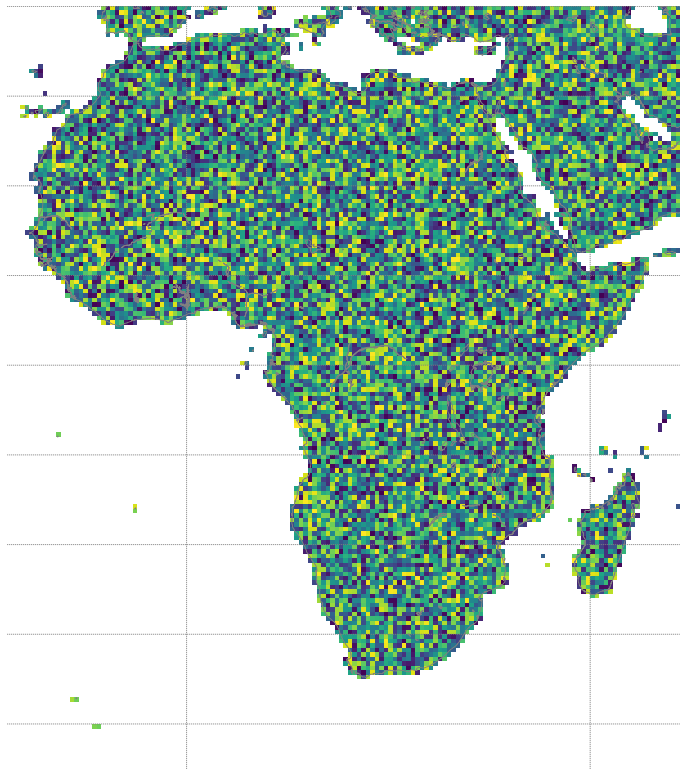

In [51]:
africa.ds['BIG_RANDOM'] = africa.ds['RANDOM'] * 2 

africa.ds['DATA'] = africa.ds['BIG_RANDOM']*africa.ds['LAND']

africa.ds['DATA'] = africa.ds['DATA'].where(africa.ds['DATA'] != 0.)  

africa.map_grid('DATA', cmap='viridis') # We only need to send the label to the function

Xarray have many option to index and select data:

In [90]:
# Numpy style index for data or coordinates:
a = africa.ds['DATA'][66, 33]
b = africa.ds.coords['lon'][66, 33]

# Select by coordinates index:
c = africa.ds['DATA'].isel(X=33, Y=66)

d = africa.ds['DATA'].sel(X=[14, 71], method='nearest')

d

<xarray.DataArray 'DATA' (Y: 170, X: 2)>
array([[     nan, 0.712156],
       [     nan, 1.924806],
       [0.853264, 0.177629],
       ...,
       [     nan,      nan],
       [     nan,      nan],
       [     nan,      nan]])
Coordinates:
  * X        (X) float32 14.228188 55.0
  * Y        (Y) float32 40.0 39.49704 38.994083 ... -43.994083 -44.49704 -45.0
    XV       (Y, X) float32 14.228188 55.0 14.228188 ... 55.0 14.228188 55.0
    YV       (Y, X) float32 40.0 40.0 39.49704 ... -44.49704 -45.0 -45.0
    lat      (Y, X) float32 40.0 40.0 39.49704 ... -44.49704 -45.0 -45.0
    lon      (Y, X) float32 14.228188 55.0 14.228188 ... 55.0 14.228188 55.0

In [80]:
d = africa.ds.coords['lon'][66, 33]
d

<xarray.DataArray 'lon' ()>
array(-3.389262, dtype=float32)
Coordinates:
    X        float32 -3.3892617
    Y        float32 6.8047338
    XV       float32 -3.3892617
    YV       float32 6.8047338
    lat      float32 6.8047338
    lon      float32 -3.3892617

In [78]:
africa.ds

<xarray.Dataset>
Dimensions:     (RGB: 3, X: 150, Y: 170, Z: 5)
Coordinates:
  * X           (X) float32 -20.0 -19.496645 -18.993288 ... 54.496643 55.0
  * Y           (Y) float32 40.0 39.49704 38.994083 ... -44.49704 -45.0
  * Z           (Z) float32 0.0 8000.0 16000.0 40000.0 350000.0
  * RGB         (RGB) <U1 'R' 'G' 'B'
    XV          (Y, X) float32 -20.0 -19.496645 -18.993288 ... 54.496643 55.0
    YV          (Y, X) float32 40.0 40.0 40.0 40.0 ... -45.0 -45.0 -45.0 -45.0
    lat         (Y, X) float32 40.0 40.0 40.0 40.0 ... -45.0 -45.0 -45.0 -45.0
    lon         (Y, X) float32 -20.0 -19.496645 -18.993288 ... 54.496643 55.0
Data variables:
    RANDOM      (Y, X) float64 0.2002 0.8797 0.2577 ... 0.3939 0.9009 0.1679
    LAND        (Y, X) bool False False False False ... False False False False
    BIG_RANDOM  (Y, X) float64 0.4004 1.759 0.5154 1.234 ... 0.7877 1.802 0.3358
    DATA        (Y, X) float64 nan nan nan nan nan nan ... nan nan nan nan nan

We can release some memory by deleting data variables or simply delete the entire object from memory. 

In [ ]:
africa.ds.drop(['RANDOM', 'BIG_RANDOM'])

#del africa 

## A detailed map

Now we try a high resolution dataset with a different projection. 

In [30]:
#Make object
bouvet = Grid(crs_tgt=32731, res = [5, 5], 
             up = 3974168, 
             left=517217 , 
             down = 3965208, 
             right = 529277)

print(bouvet.ds)

<xarray.Dataset>
Dimensions:  (RGB: 3, X: 2412, Y: 1792, Z: 5)
Coordinates:
  * X        (X) float32 517217.0 517222.0 517227.0 ... 529272.0 529277.0
  * Y        (Y) float32 3974168.0 3974163.0 3974158.0 ... 3965213.0 3965208.0
  * Z        (Z) float32 0.0 8000.0 16000.0 40000.0 350000.0
  * RGB      (RGB) <U1 'R' 'G' 'B'
    XV       (Y, X) float32 dask.array<shape=(1792, 2412), chunksize=(179, 241)>
    YV       (Y, X) float32 dask.array<shape=(1792, 2412), chunksize=(179, 241)>
    lat      (Y, X) float32 dask.array<shape=(1792, 2412), chunksize=(179, 241)>
    lon      (Y, X) float32 dask.array<shape=(1792, 2412), chunksize=(179, 241)>
Data variables:
    *empty*


Again, we download some data, both raster and vector. Ref: [Norwegian Polar Institute 2014](https://data.npolar.no/dataset/19700322-beab-40e7-b867-c3f0c2756071)

In [42]:
! mkdir -p data/bouvet

! wget -nc https://publicdatasets.data.npolar.no/kartdata/NP_B0_DTM20.zip \
    -O data/bouvet/NP_B0_DTM20.zip 
! unzip -n data/bouvet/NP_B0_DTM20.zip -d data/bouvet

! wget -nc https://publicdatasets.data.npolar.no/kartdata/NP_B20_SHP.zip \
    -O data/bouvet/NP_B20_SHP.zip
! unzip -n data/bouvet/NP_B20_SHP.zip -d data/bouvet

! wget -nc https://content.satimagingcorp.com/static/galleryimages/landsat%208%20bouvet%20island%20lg.jpg \
    -O data/bouvet/landsat_bouvet.jpg

File ‘data/bouvet/NP_B0_DTM20.zip’ already there; not retrieving.
Archive:  data/bouvet/NP_B0_DTM20.zip
File ‘data/bouvet/NP_B20_SHP.zip’ already there; not retrieving.
Archive:  data/bouvet/NP_B20_SHP.zip
File ‘data/bouvet/landsat_bouvet.jpg’ already there; not retrieving.


In [38]:
bouvet.ds['DEM'] = (('Y', 'X'), 
                bouvet.read_raster('data/bovet/NP_B0_DTM20/B0_DTM20.tif'))

bouvet.map_grid('DEM', cmap='terrain', cbar=True, vmax=3000, vmin=-3000)

CRS({'init': 'epsg:32731'})


In [33]:
bouvet.ds['LAND'] = (('Y', 'X'), 
                     bovet.assign_shape('data/bovet/NP_B20_SHP/B20_Land_f.shp', None, burn_val=1) )

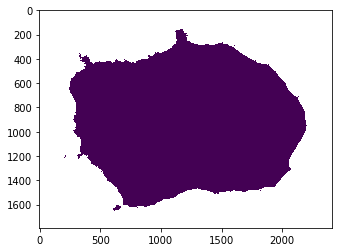

In [34]:
plt.imshow(bouvet.ds['LAND'].values)
plt.show()

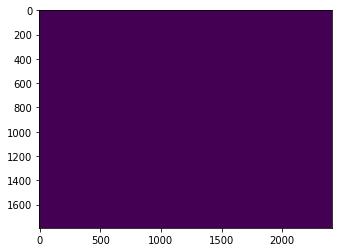

In [36]:
plt.imshow(bouvet.ds['DEM'].values)
plt.show()